# Quantized pre-trainer Visualization

Visualize the results from the quantized pre-trainer inference on random dataset images.

Start by importing the model builder and building the model.

In [5]:
import sys
sys.path.append("../")
from multitudinous.utils.model_builder import build_img_pretraining, build_img_backbone
import torch

ENCODER_VARIANT = "resnet50"
PRETRAINER_VARIANT = "ae"
ENCODER_WEIGHTS = "../resnet_ae_q/resnet50_quantized.pth"
PRETRAINER_WEIGHTS = "../resnet50_ae/img_pretrainer_15.pth"
BATCH_SIZE = 4

# build the model
model = build_img_pretraining(f"{ENCODER_VARIANT}_{PRETRAINER_VARIANT}", 4, PRETRAINER_WEIGHTS)

Now, create the quantized encoder:

In [6]:
from multitudinous.utils.quantization import get_quantized_model

encoder_fp32 = build_img_backbone(ENCODER_VARIANT, 4)

encoder_quant = get_quantized_model(encoder_fp32)
encoder_quant.load_state_dict(torch.load(ENCODER_WEIGHTS))
encoder_quant.eval()

# replace the encoder with the quantized version
model.encoder = encoder_quant
model.eval()

/home/carlostojal/anaconda3/envs/multitudinous/lib/python3.12/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/carlostojal/anaconda3/envs/multitudinous/lib/python3.12/site-packages/torch/ao/quantization/observer.py:1263: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


ResNet50AE(
  (encoder): ResNet50(
    (conv1): QuantizedConv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.327205628156662, zero_point=67, padding=(3, 3), bias=False)
    (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BottleneckBlock(
        (conv1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.3981229066848755, zero_point=68, bias=False)
        (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout2d(p=0.5, inplace=False)
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.750064730644226, zero_point=75, padding=(1, 1), bias=False)
        (bn2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout2): Dropout2d(p=0.5, inplace=Fals

Now we need to import the dataset builder and build the dataset.

In [7]:
from multitudinous.utils.dataset_builder import build_img_dataset
from torch.utils.data import DataLoader

# build the dataset
_, _, test_set = build_img_dataset("tum_rgbd", "../../data/tum_rgbd2", "train", "val", "test")

# create the dataloader
dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/tum_rgbd3/train/rgb'

Now, run inference and visualize on "x" random samples from the dataset.

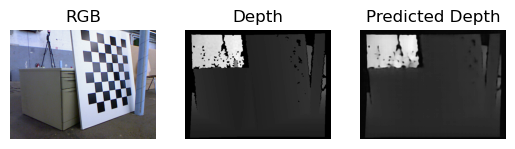

Sample 1/100 - RMSE: 0.0460970364511013, Abs Rel: 0.11080101132392883, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0 

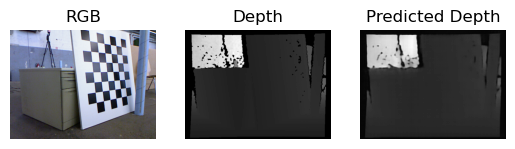

Sample 2/100 - RMSE: 0.046736910939216614, Abs Rel: 0.11143308877944946, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0 

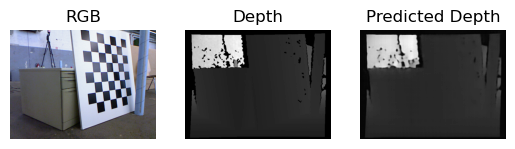

Sample 70/100 - RMSE: 0.03672393038868904, Abs Rel: 0.10484737902879715, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0  

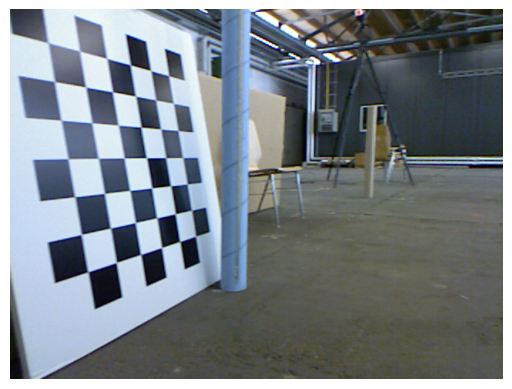

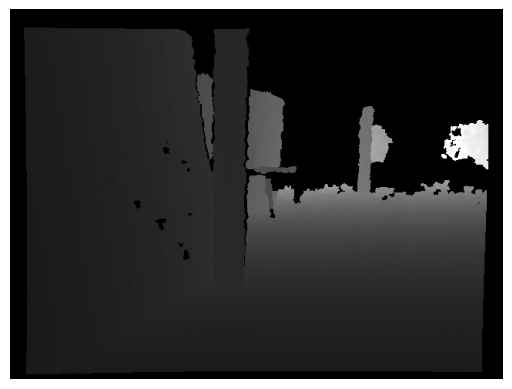

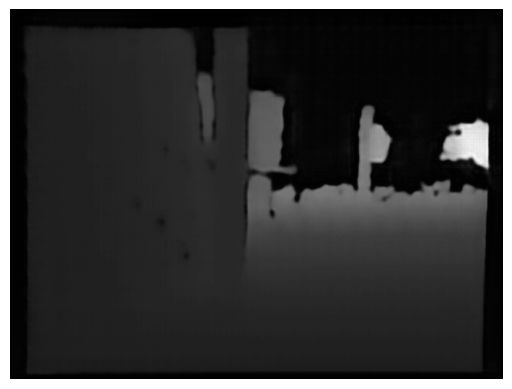

Sample 100/100 - RMSE: 0.0372031107544899, Abs Rel: 0.09469613432884216, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0  
RMSE: 0.0372031107544899, Abs Rel: 0.09469613432884216, Delta1: 1.0, Delta2: 1.0, Delta3: 1.0


In [ ]:
import matplotlib.pyplot as plt
import torch
from multitudinous.loss_fns import rmse, rel, delta

NUM_VIZ_SAMPLES = 3
FIXED_VIZ_SAMPLE = 70 # number of the always visualized sample
NUM_EVAL_SAMPLES = 100

visualized_count = 0

rmse_total = 0
abs_rel_total = 0
delta1_total = 0
delta2_total = 0
delta3_total = 0
count = 0
total_samples = len(dataloader)

# run inference on the samples
for rgb, depth in dataloader:

    pred = None

    # build the rgb-d sample
    if len(depth.shape) == 2: # if HxW
        rgb = rgb.unsqueeze(0) # unsqueeze the batch dimension
    depth = depth.unsqueeze(1) # unsqueeze the channel dimension
    rgbd = torch.cat((rgb, depth), dim=1)
    
    # run inference
    with torch.no_grad():
        # move the sample to the device
        preds = model(rgbd)

        i = 0

    for p in preds:

        # calculate the metrics
        p = p.squeeze()
        d = depth[i].squeeze()
        r = rgb[i].squeeze()

        rmse_total += rmse(p, d)
        abs_rel_total += rel(p, d)
        delta1_total += delta(p, d, 1.25)
        delta2_total += delta(p, d, 1.25**2)
        delta3_total += delta(p, d, 1.25**3)

        # ----------------------
    
        # visualize the results
        if visualized_count < NUM_VIZ_SAMPLES:

            visualized_count += 1

            # plot the results
            plt.subplot(1, 3, 1)
            plt.imshow(r.permute(1, 2, 0))
            plt.title("RGB")
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(d.squeeze(0), cmap="gray")
            plt.title("Depth")
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(p.squeeze(), cmap="gray")
            plt.title("Predicted Depth")
            plt.axis("off")
            plt.show()

        if count == FIXED_VIZ_SAMPLE:

            # plot the color image
            plt.imshow(r.permute(1, 2, 0))
            plt.axis("off")
            plt.show()

            # plot the ground truth
            plt.imshow(d.squeeze(0), cmap="gray")
            plt.axis("off")
            plt.show()

            # plot the prediction
            plt.imshow(p.squeeze(), cmap="gray")
            plt.axis("off")
            plt.show()

        i += 1
        count += 1

        print(f"\rSample {count}/{NUM_EVAL_SAMPLES} - RMSE: {rmse_total/count}, Abs Rel: {abs_rel_total/count}, Delta1: {delta1_total/count}, Delta2: {delta2_total/count}, Delta3: {delta3_total/count}", end=" ")

    if count >= NUM_EVAL_SAMPLES:
        break

    del pred, rgb, depth

# clean up
del model, test_set, dataloader

# print the metrics
print(f"\nRMSE: {rmse_total/count}, Abs Rel: {abs_rel_total/count}, Delta1: {delta1_total/count}, Delta2: {delta2_total/count}, Delta3: {delta3_total/count}")